In [1]:
%pip install -qq -U datasets transformers pyarrow==9.0.0
%pip install -qq --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 115.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import sys
from base64 import b64encode
import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os
import cv2
import torchvision.transforms as T

torch.manual_seed(1)
logging.set_verbosity_error()
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [3]:

# Load the autoencoder
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='vae')

# Load tokenizer and text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# Unet model for generating latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='unet')

# Noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# Move everything to GPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)


In [4]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [5]:

# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925


In [6]:
def get_style_embeddings(style_file):
    style_embed = torch.load(style_file)
    style_name = list(style_embed.keys())[0]
    return style_embed[style_name]

def get_EOS_pos_in_prompt(prompt):
    return len(prompt.split())+1

In [7]:
from torchvision.transforms import ToTensor
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images


def additional_guidance(latents, scheduler, noise_pred, t, sigma, custom_loss_fn, custom_loss_scale):
    #### ADDITIONAL GUIDANCE ###
    # Requires grad on the latents
    latents = latents.detach().requires_grad_()

    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred
    #print(f"latents: {latents.shape}, noise_pred:{noise_pred.shape}")
    #latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

    # Decode to image space
    denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

    # Calculate loss
    loss = custom_loss_fn(denoised_images) * custom_loss_scale

    # Get gradient
    cond_grad = torch.autograd.grad(loss, latents, allow_unused=False)[0]

    # Modify the latents based on this gradient
    latents = latents.detach() - cond_grad * sigma**2
    return latents, loss


def generate_with_embs(text_embeddings, max_length, random_seed, loss_fn = None, custom_loss_scale=1.0):


    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5
    generator = torch.manual_seed(random_seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        if loss_fn is not None:
            if i%2 == 0:
                latents, custom_loss = additional_guidance(latents, scheduler, noise_pred, t, sigma, loss_fn, custom_loss_scale)
                print(i, 'loss:', custom_loss.item())

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [8]:
def generate_image_custom_style(prompt, style_num=None, random_seed=41, custom_loss_fn=None, custom_loss_scale=1.0):
    # Find the position of the end of sentence (EOS) in the prompt.
    eos_pos = get_EOS_pos_in_prompt(prompt)

    # Retrieve style token embeddings if a style number is specified.
    style_token_embedding = None
    if style_num:
        style_token_embedding = get_style_embeddings(style_files[style_num])

    # Tokenize the input text using the tokenizer.
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    max_length = text_input.input_ids.shape[-1]
    input_ids = text_input.input_ids.to(torch_device)

    # Obtain token embeddings from the text model.
    token_emb_layer = text_encoder.text_model.embeddings.token_embedding
    token_embeddings = token_emb_layer(input_ids)

    # Append the style token towards the end of the sentence embeddings if a style is selected.
    if style_token_embedding is not None:
        token_embeddings[-1, eos_pos, :] = style_token_embedding

    # Combine token embeddings with position embeddings.
    pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
    position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
    position_embeddings = pos_emb_layer(position_ids)
    input_embeddings = token_embeddings + position_embeddings

    # Feed the input embeddings to get modified output embeddings.
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # Generate an image using the modified embeddings.
    generated_image = generate_with_embs(modified_output_embeddings, max_length, random_seed, custom_loss_fn, custom_loss_scale)

    return generated_image


In [9]:
def show_images(images_list,image_names):
    # Let's visualize the four channels of this latent representation:
    fig, axs = plt.subplots(1, len(images_list), figsize=(16, 4))
    for c in range(len(images_list)):
        axs[c].imshow(images_list[c])
        axs[c].set_title(image_names[c])

    plt.show()

In [10]:
import torch.nn.functional as F

def sharpness_loss(images):
    # Apply the Laplacian filter to the images to measure sharpness.
    laplacian_filter = torch.Tensor([[-1, -1, -1],
                                    [-1, 8, -1],
                                    [-1, -1, -1]]).view(1, 1, 3, 3).to(images.device)

    # Expand the filter to match the number of channels in the input image.
    laplacian_filter = laplacian_filter.expand(-1, images.shape[1], -1, -1)

    # Apply the convolution operation.
    laplacian = torch.abs(F.conv2d(images, laplacian_filter))

    # Calculate sharpness as the negative of the Laplacian variance.
    sharpness = torch.var(laplacian)
    return sharpness


outputs_no_loss = []
outputs_loss = []
image_names=["animal toy","fft style","mid journey","oil style","Space style"]
style_files = ['/content/embeddings/learned_embeds_animal_toys.bin','/content/embeddings/learned_embeds_fftstyle.bin',
          '/content/embeddings/learned_embeds_midjourney_style.bin','/content/embeddings/learned_embeds_oil_style.bin','/content/embeddings/learned_embeds_space-style.bin']
seed_values = [101,102,103,104,106]
prompt = " A ballerina cat dancing in space"
custom_loss = sharpness_loss
custom_loss_scale = 100.0
num_styles = len(style_files)
for count in range(num_styles):

    generated_img_no_loss = generate_image_custom_style(prompt,
                                                        style_num = count,
                                                        random_seed = seed_values[count],
                                                        custom_loss_fn = None,
                                                        custom_loss_scale = custom_loss_scale)
    outputs_no_loss.append(generated_img_no_loss)
    generated_img_loss = generate_image_custom_style(prompt,
                                                        style_num = count,
                                                        random_seed = seed_values[count],
                                                        custom_loss_fn = custom_loss,
                                                        custom_loss_scale = custom_loss_scale)
    outputs_loss.append(generated_img_loss)


<ipython-input-7-4c8373d1b5b4>:66: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 2.4639251232147217
2 loss: 0.19320331513881683
4 loss: 0.1830805391073227
6 loss: 4.697305679321289
8 loss: 4.024259567260742
10 loss: 4.6493144035339355
12 loss: 5.7189836502075195
14 loss: 5.00476598739624
16 loss: 5.34870719909668
18 loss: 4.325726509094238
20 loss: 2.657050371170044
22 loss: 2.3041460514068604
24 loss: 2.1363115310668945
26 loss: 2.028172016143799
28 loss: 1.9325053691864014


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 18.19132423400879
2 loss: 25.87662124633789
4 loss: 24.547744750976562
6 loss: 23.207212448120117
8 loss: 22.454853057861328
10 loss: 22.08356285095215
12 loss: 21.90363311767578
14 loss: 21.802827835083008
16 loss: 21.75482749938965
18 loss: 21.748504638671875
20 loss: 21.774511337280273
22 loss: 21.823787689208984
24 loss: 21.887405395507812
26 loss: 21.95686149597168
28 loss: 22.02519989013672


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 6.023711204528809
2 loss: 184.56939697265625
4 loss: 79.25365447998047
6 loss: 81.04566192626953
8 loss: 81.15374755859375
10 loss: 81.23246765136719
12 loss: 81.2908706665039
14 loss: 81.32943725585938
16 loss: 81.35631561279297
18 loss: 81.37598419189453
20 loss: 81.39004516601562
22 loss: 81.39863586425781
24 loss: 81.40589904785156
26 loss: 81.41119384765625
28 loss: 81.41316223144531


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 18.22450065612793
2 loss: 17.67351722717285
4 loss: 14.428504943847656
6 loss: 13.076545715332031
8 loss: 12.43393611907959
10 loss: 12.123796463012695
12 loss: 12.0271577835083
14 loss: 12.0717134475708
16 loss: 12.13741397857666
18 loss: 12.196942329406738
20 loss: 12.283210754394531
22 loss: 12.407894134521484
24 loss: 12.567570686340332
26 loss: 12.74862003326416
28 loss: 12.950672149658203


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 8.597817420959473
2 loss: 4.3387627601623535
4 loss: 0.8475226163864136
6 loss: 2.1515309810638428
8 loss: 3.739219903945923
10 loss: 6.044650077819824
12 loss: 5.013354301452637
14 loss: 5.380793571472168
16 loss: 7.633846282958984
18 loss: 8.294849395751953
20 loss: 8.49990463256836
22 loss: 9.012694358825684
24 loss: 9.530858993530273
26 loss: 10.079998016357422
28 loss: 10.911108016967773


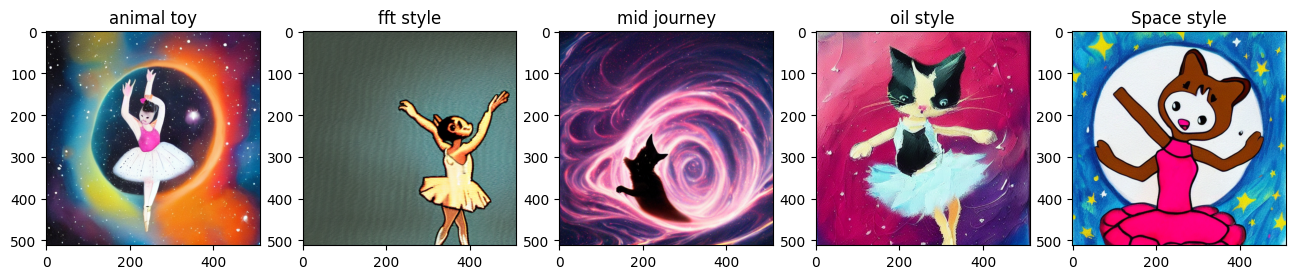

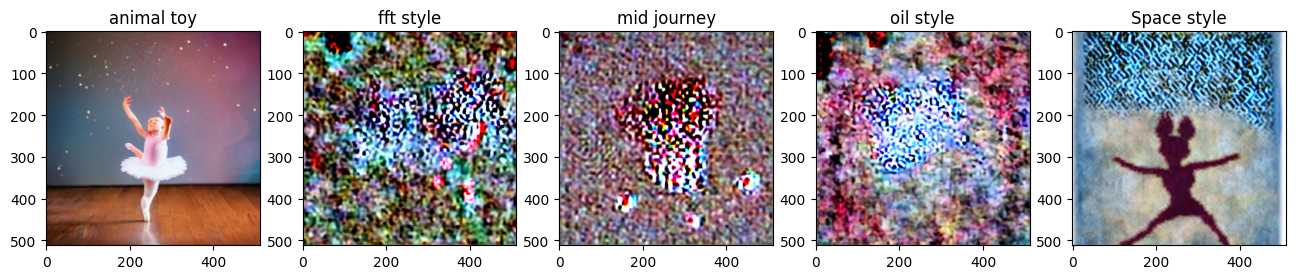

In [11]:
show_images(outputs_no_loss,image_names)
show_images(outputs_loss,image_names)

In [12]:
def color_diversity_loss(images):
    # Calculate color diversity by measuring the variance of color channels (R, G, B).
    color_variance = torch.var(images, dim=(2, 3), keepdim=True)
    # Sum the color variances for each channel to get the total color diversity.
    total_color_diversity = torch.sum(color_variance, dim=1)
    return total_color_diversity



outputs_no_loss = []
outputs_loss = []
image_names=["animal toy","fft style","mid journey","oil style","Space style"]
style_files = ['/content/embeddings/learned_embeds_animal_toys.bin','/content/embeddings/learned_embeds_fftstyle.bin',
          '/content/embeddings/learned_embeds_midjourney_style.bin','/content/embeddings/learned_embeds_oil_style.bin','/content/embeddings/learned_embeds_space-style.bin']
seed_values = [101,102,103,104,106]
prompt = " A ballerina cat dancing in space"
custom_loss = color_diversity_loss
custom_loss_scale = 100.0
num_styles = len(style_files)
for count in range(num_styles):

    generated_img_no_loss = generate_image_custom_style(prompt,
                                                        style_num = count,
                                                        random_seed = seed_values[count],
                                                        custom_loss_fn = None,
                                                        custom_loss_scale = custom_loss_scale)
    outputs_no_loss.append(generated_img_no_loss)
    generated_img_loss = generate_image_custom_style(prompt,
                                                        style_num = count,
                                                        random_seed = seed_values[count],
                                                        custom_loss_fn = custom_loss,
                                                        custom_loss_scale = custom_loss_scale)
    outputs_loss.append(generated_img_loss)


<ipython-input-7-4c8373d1b5b4>:66: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 15.254295349121094
2 loss: 5.819066047668457
4 loss: 3.5173282623291016
6 loss: 2.573733329772949
8 loss: 2.251821279525757
10 loss: 2.1892096996307373
12 loss: 2.357783079147339
14 loss: 2.4765570163726807
16 loss: 2.4067184925079346
18 loss: 2.4420201778411865
20 loss: 2.445294141769409
22 loss: 2.439995527267456
24 loss: 2.4645206928253174
26 loss: 2.5060205459594727
28 loss: 2.5666003227233887


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 12.080951690673828
2 loss: 3.3112010955810547
4 loss: 2.5944480895996094
6 loss: 2.3958754539489746
8 loss: 2.342780590057373
10 loss: 2.284360885620117
12 loss: 2.2951717376708984
14 loss: 2.341599702835083
16 loss: 2.4213194847106934
18 loss: 2.536163568496704
20 loss: 2.6726348400115967
22 loss: 2.7584471702575684
24 loss: 2.8158645629882812
26 loss: 2.863515853881836
28 loss: 2.904362916946411


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 7.706965446472168
2 loss: 13.772198677062988
4 loss: 14.406387329101562
6 loss: 15.75671100616455
8 loss: 9.745265007019043
10 loss: 8.20931625366211
12 loss: 11.199899673461914
14 loss: 8.375575065612793
16 loss: 7.4835524559021
18 loss: 6.901256084442139
20 loss: 6.590680122375488
22 loss: 6.635254859924316
24 loss: 6.757080554962158
26 loss: 6.848544597625732
28 loss: 7.00004243850708


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 17.619571685791016
2 loss: 24.54446792602539
4 loss: 17.936187744140625
6 loss: 18.584178924560547
8 loss: 13.519990921020508
10 loss: 10.327313423156738
12 loss: 9.175896644592285
14 loss: 9.013401985168457
16 loss: 9.073348999023438
18 loss: 9.046671867370605
20 loss: 9.109753608703613
22 loss: 9.405924797058105
24 loss: 9.63274097442627
26 loss: 9.863395690917969
28 loss: 10.147479057312012


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 17.609378814697266
2 loss: 3.740478038787842
4 loss: 6.8005547523498535
6 loss: 4.370541095733643
8 loss: 2.7829482555389404
10 loss: 2.805067539215088
12 loss: 3.4839630126953125
14 loss: 3.7156076431274414
16 loss: 3.1645455360412598
18 loss: 3.123950481414795
20 loss: 3.1741433143615723
22 loss: 3.219256639480591
24 loss: 3.2835147380828857
26 loss: 3.369107484817505
28 loss: 3.4833240509033203


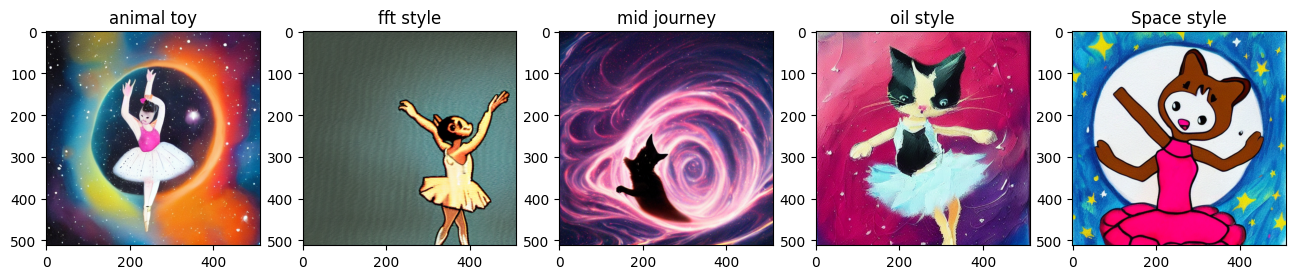

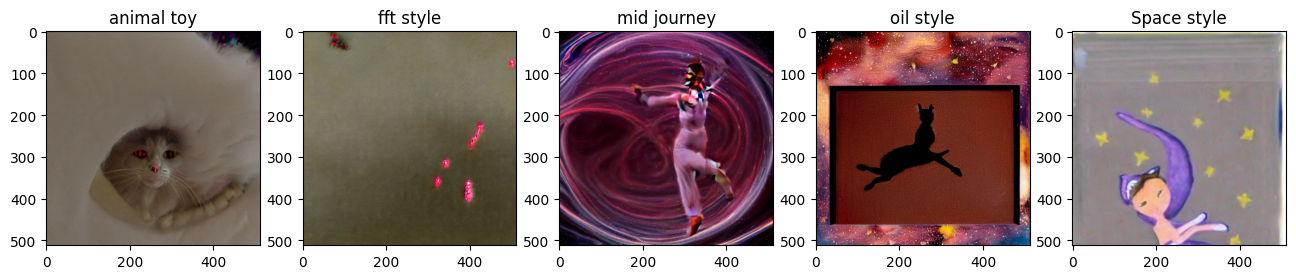

In [13]:
show_images(outputs_no_loss,image_names)
show_images(outputs_loss,image_names)

In [14]:
import numpy as np
from PIL import Image

import torch
from scipy.stats import wasserstein_distance

def exposure_loss(image, target_exposure = 3):
    # Calculate the brightness (exposure) of the image.
    image_brightness = torch.mean(image)

    # Calculate the loss as the absolute difference from the target exposure.
    loss = torch.abs(image_brightness - target_exposure)
    return loss


outputs_no_loss = []
outputs_loss = []
image_names=["animal toy","fft style","mid journey","oil style","Space style"]
style_files = ['/content/embeddings/learned_embeds_animal_toys.bin','/content/embeddings/learned_embeds_fftstyle.bin',
          '/content/embeddings/learned_embeds_midjourney_style.bin','/content/embeddings/learned_embeds_oil_style.bin','/content/embeddings/learned_embeds_space-style.bin']
seed_values = [101,102,103,104,106]
prompt = " A ballerina cat dancing in space"
custom_loss = exposure_loss
custom_loss_scale = 100.0
num_styles = len(style_files)
for count in range(num_styles):

    generated_img_no_loss = generate_image_custom_style(prompt,
                                                        style_num = count,
                                                        random_seed = seed_values[count],
                                                        custom_loss_fn = None,
                                                        custom_loss_scale = custom_loss_scale)
    outputs_no_loss.append(generated_img_no_loss)
    generated_img_loss = generate_image_custom_style(prompt,
                                                        style_num = count,
                                                        random_seed = seed_values[count],
                                                        custom_loss_fn = custom_loss,
                                                        custom_loss_scale = custom_loss_scale)
    outputs_loss.append(generated_img_loss)


<ipython-input-7-4c8373d1b5b4>:66: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 256.72406005859375
2 loss: 222.66159057617188
4 loss: 214.2144012451172
6 loss: 211.1948699951172
8 loss: 208.66305541992188
10 loss: 218.48512268066406
12 loss: 212.64859008789062
14 loss: 211.98985290527344
16 loss: 212.015869140625
18 loss: 210.5243682861328
20 loss: 210.54258728027344
22 loss: 210.4890594482422
24 loss: 210.37997436523438
26 loss: 210.3308868408203
28 loss: 210.26828002929688


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 263.4206848144531
2 loss: 219.43826293945312
4 loss: 215.88943481445312
6 loss: 214.88380432128906
8 loss: 210.68734741210938
10 loss: 213.59388732910156
12 loss: 212.83822631835938
14 loss: 213.01937866210938
16 loss: 212.31045532226562
18 loss: 211.23695373535156
20 loss: 210.9422607421875
22 loss: 210.7879638671875
24 loss: 210.7505340576172
26 loss: 210.7400360107422
28 loss: 210.75071716308594


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 257.0254211425781
2 loss: 223.35293579101562
4 loss: 216.53204345703125
6 loss: 215.65402221679688
8 loss: 212.6586456298828
10 loss: 213.14175415039062
12 loss: 211.86679077148438
14 loss: 212.23594665527344
16 loss: 211.1131591796875
18 loss: 210.5597686767578
20 loss: 210.52772521972656
22 loss: 210.48292541503906
24 loss: 210.38818359375
26 loss: 210.2255859375
28 loss: 210.03964233398438


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 250.39515686035156
2 loss: 226.6986083984375
4 loss: 214.0166778564453
6 loss: 208.92080688476562
8 loss: 207.2002410888672
10 loss: 207.85977172851562
12 loss: 210.27464294433594
14 loss: 209.7880096435547
16 loss: 208.90087890625
18 loss: 209.40792846679688
20 loss: 208.09173583984375
22 loss: 207.27980041503906
24 loss: 207.05633544921875
26 loss: 206.8438262939453
28 loss: 206.68382263183594


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 244.3359832763672
2 loss: 214.29164123535156
4 loss: 212.25277709960938
6 loss: 211.22885131835938
8 loss: 213.62901306152344
10 loss: 209.36216735839844
12 loss: 211.7675018310547
14 loss: 209.99879455566406
16 loss: 208.87005615234375
18 loss: 208.85743713378906
20 loss: 208.85382080078125
22 loss: 208.66055297851562
24 loss: 208.5000762939453
26 loss: 208.3580780029297
28 loss: 208.24549865722656


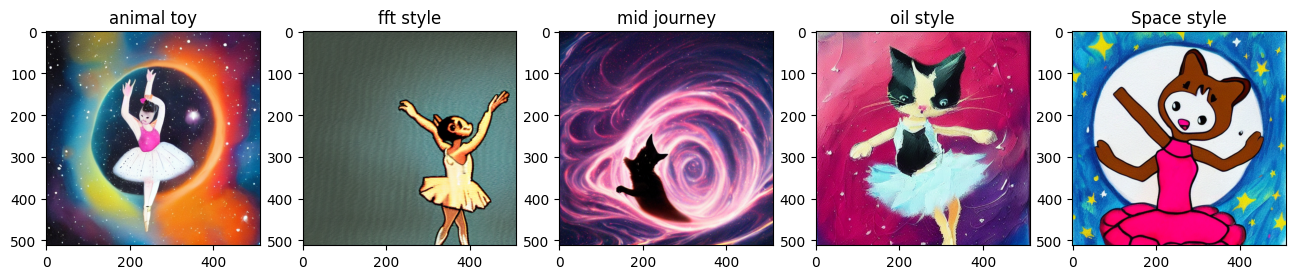

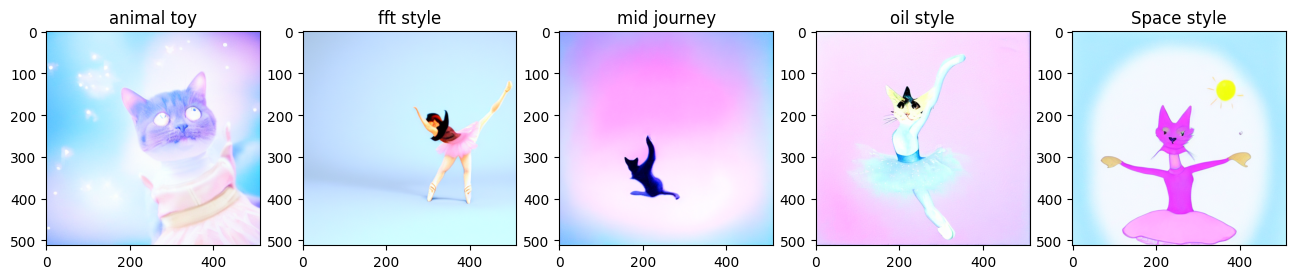

In [15]:
show_images(outputs_no_loss,image_names)
show_images(outputs_loss,image_names)

In [16]:
def brilliance_loss(image, target_brilliance=10):
    # Calculate the standard deviation of color channels
    std_dev = torch.std(image, dim=(2, 3))
    # Calculate the mean standard deviation across the batch
    mean_std_dev = torch.mean(std_dev)
    # Calculate the loss as the absolute difference from the target brilliance.
    loss = torch.abs(mean_std_dev - target_brilliance)
    return loss


outputs_no_loss = []
outputs_loss = []
image_names=["animal toy","fft style","mid journey","oil style","Space style"]
style_files = ['/content/embeddings/learned_embeds_animal_toys.bin','/content/embeddings/learned_embeds_fftstyle.bin',
          '/content/embeddings/learned_embeds_midjourney_style.bin','/content/embeddings/learned_embeds_oil_style.bin','/content/embeddings/learned_embeds_space-style.bin']
seed_values = [101,102,103,104,106]
prompt = " A ballerina cat dancing in space"
custom_loss = brilliance_loss
custom_loss_scale = 100.0
num_styles = len(style_files)
for count in range(num_styles):

    generated_img_no_loss = generate_image_custom_style(prompt,
                                                        style_num = count,
                                                        random_seed = seed_values[count],
                                                        custom_loss_fn = None,
                                                        custom_loss_scale = custom_loss_scale)
    outputs_no_loss.append(generated_img_no_loss)
    generated_img_loss = generate_image_custom_style(prompt,
                                                        style_num = count,
                                                        random_seed = seed_values[count],
                                                        custom_loss_fn = custom_loss,
                                                        custom_loss_scale = custom_loss_scale)
    outputs_loss.append(generated_img_loss)

<ipython-input-7-4c8373d1b5b4>:66: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 978.0034790039062
2 loss: 966.7850341796875
4 loss: 966.834716796875
6 loss: 968.3743286132812
8 loss: 961.1090698242188
10 loss: 961.8099975585938
12 loss: 959.4989013671875
14 loss: 958.8397827148438
16 loss: 958.5042114257812
18 loss: 957.9148559570312
20 loss: 957.5037841796875
22 loss: 957.1813354492188
24 loss: 956.9598999023438
26 loss: 956.7946166992188
28 loss: 956.683837890625


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 979.990966796875
2 loss: 962.8062133789062
4 loss: 962.246826171875
6 loss: 958.6356201171875
8 loss: 957.2774047851562
10 loss: 956.8572998046875
12 loss: 955.6585083007812
14 loss: 955.6637573242188
16 loss: 955.1046142578125
18 loss: 954.8526611328125
20 loss: 954.7068481445312
22 loss: 954.640869140625
24 loss: 954.5808715820312
26 loss: 954.5321655273438
28 loss: 954.4609375


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 984.1401977539062
2 loss: 969.3461303710938
4 loss: 970.1828002929688
6 loss: 968.178466796875
8 loss: 966.9638671875
10 loss: 965.48681640625
12 loss: 964.1019897460938
14 loss: 963.387939453125
16 loss: 962.8190307617188
18 loss: 962.2720947265625
20 loss: 961.9189453125
22 loss: 961.7162475585938
24 loss: 961.595947265625
26 loss: 961.45751953125
28 loss: 961.3140869140625


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 976.025390625
2 loss: 972.950927734375
4 loss: 975.9476928710938
6 loss: 975.5582885742188
8 loss: 974.3509521484375
10 loss: 973.2496948242188
12 loss: 969.2708129882812
14 loss: 966.5879516601562
16 loss: 966.1915893554688
18 loss: 965.7142333984375
20 loss: 965.2745361328125
22 loss: 964.8941040039062
24 loss: 964.5971069335938
26 loss: 964.3123779296875
28 loss: 963.97021484375


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 977.4669799804688
2 loss: 968.2891845703125
4 loss: 964.0018310546875
6 loss: 961.9592895507812
8 loss: 962.9558715820312
10 loss: 959.3134765625
12 loss: 957.1056518554688
14 loss: 957.0110473632812
16 loss: 956.5082397460938
18 loss: 956.1961059570312
20 loss: 956.001953125
22 loss: 955.8861694335938
24 loss: 955.76220703125
26 loss: 955.6427001953125
28 loss: 955.455810546875


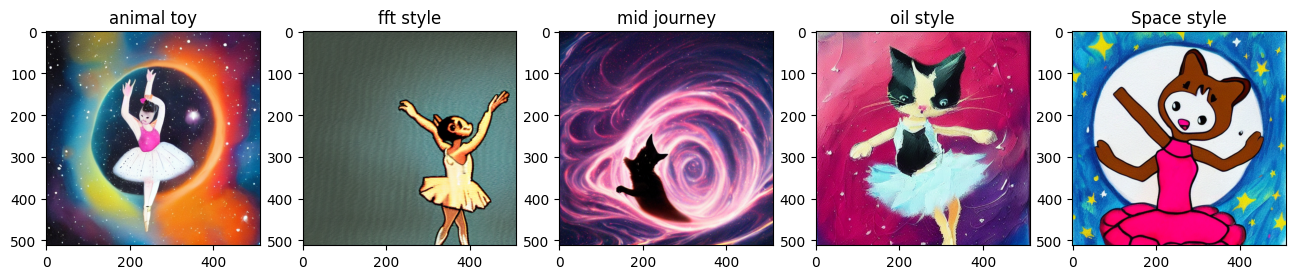

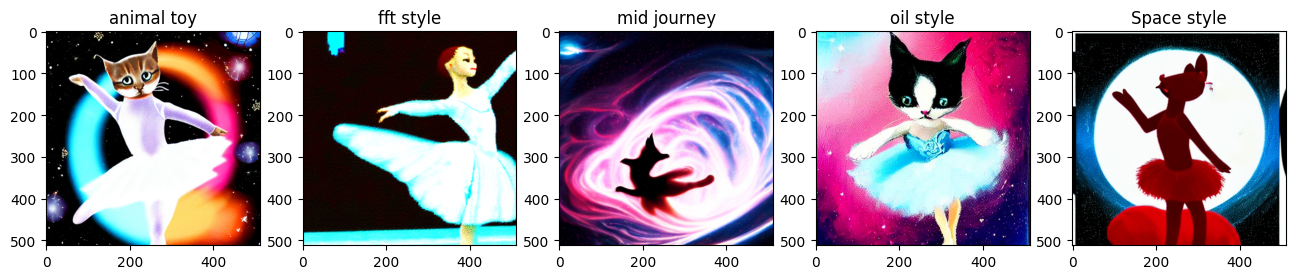

In [17]:
show_images(outputs_no_loss,image_names)
show_images(outputs_loss,image_names)

In [18]:
def contrast_loss(images):
    # Calculate the variance of pixel values as a measure of contrast.
    variance = torch.var(images)
    return -variance

outputs_no_loss = []
outputs_loss = []
image_names=["animal toy","fft style","mid journey","oil style","Space style"]
style_files = ['/content/embeddings/learned_embeds_animal_toys.bin','/content/embeddings/learned_embeds_fftstyle.bin',
          '/content/embeddings/learned_embeds_midjourney_style.bin','/content/embeddings/learned_embeds_oil_style.bin','/content/embeddings/learned_embeds_space-style.bin']
seed_values = [101,102,103,104,106]
prompt = " A ballerina cat dancing in space"
custom_loss = contrast_loss
custom_loss_scale = 100.0
num_styles = len(style_files)
for count in range(num_styles):

    generated_img_no_loss = generate_image_custom_style(prompt,
                                                        style_num = count,
                                                        random_seed = seed_values[count],
                                                        custom_loss_fn = None,
                                                        custom_loss_scale = custom_loss_scale)
    outputs_no_loss.append(generated_img_no_loss)
    generated_img_loss = generate_image_custom_style(prompt,
                                                        style_num = count,
                                                        random_seed = seed_values[count],
                                                        custom_loss_fn = custom_loss,
                                                        custom_loss_scale = custom_loss_scale)
    outputs_loss.append(generated_img_loss)


<ipython-input-7-4c8373d1b5b4>:66: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: -6.074581146240234
2 loss: -8.486858367919922
4 loss: -10.025492668151855
6 loss: -9.824641227722168
8 loss: -12.021629333496094
10 loss: -10.385747909545898
12 loss: -11.583232879638672
14 loss: -13.361997604370117
16 loss: -14.219535827636719
18 loss: -14.490509033203125
20 loss: -14.50645923614502
22 loss: -14.690468788146973
24 loss: -14.80873966217041
26 loss: -14.85802936553955
28 loss: -14.95181941986084


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: -4.108841896057129
2 loss: -11.574176788330078
4 loss: -14.576011657714844
6 loss: -15.847214698791504
8 loss: -17.79934310913086
10 loss: -17.69074821472168
12 loss: -19.957822799682617
14 loss: -20.202198028564453
16 loss: -20.445783615112305
18 loss: -20.879148483276367
20 loss: -21.060577392578125
22 loss: -21.235864639282227
24 loss: -21.362260818481445
26 loss: -21.478261947631836
28 loss: -21.565746307373047


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: -7.039851665496826
2 loss: -10.268848419189453
4 loss: -7.286198616027832
6 loss: -8.467693328857422
8 loss: -8.872984886169434
10 loss: -9.822649955749512
12 loss: -11.715137481689453
14 loss: -12.934369087219238
16 loss: -13.627565383911133
18 loss: -14.069719314575195
20 loss: -14.324352264404297
22 loss: -14.539660453796387
24 loss: -14.756278991699219
26 loss: -15.022550582885742
28 loss: -15.301963806152344


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: -9.40951919555664
2 loss: -10.762669563293457
4 loss: -11.507067680358887
6 loss: -9.221175193786621
8 loss: -8.264331817626953
10 loss: -7.899684429168701
12 loss: -11.928000450134277
14 loss: -12.726805686950684
16 loss: -13.376734733581543
18 loss: -13.682185173034668
20 loss: -13.672675132751465
22 loss: -13.596049308776855
24 loss: -13.602479934692383
26 loss: -13.758218765258789
28 loss: -13.984577178955078


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: -6.364677906036377
2 loss: -10.044629096984863
4 loss: -11.178157806396484
6 loss: -10.025360107421875
8 loss: -10.02847957611084
10 loss: -9.668338775634766
12 loss: -9.765167236328125
14 loss: -11.648444175720215
16 loss: -12.306482315063477
18 loss: -12.901806831359863
20 loss: -13.013139724731445
22 loss: -13.185002326965332
24 loss: -13.383610725402832
26 loss: -13.622316360473633
28 loss: -13.985751152038574


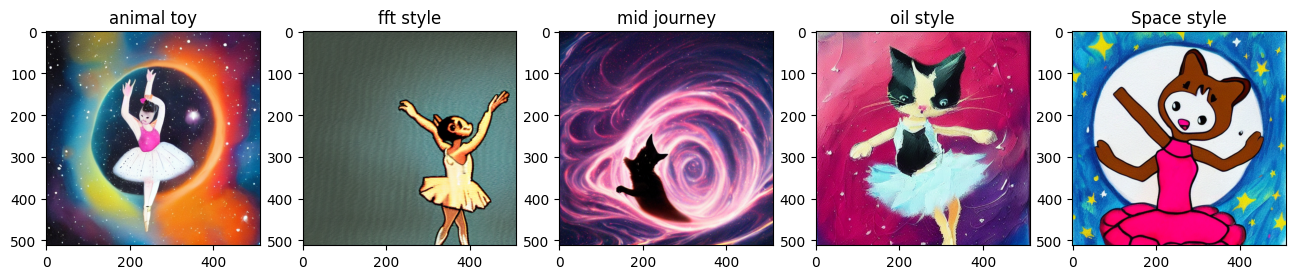

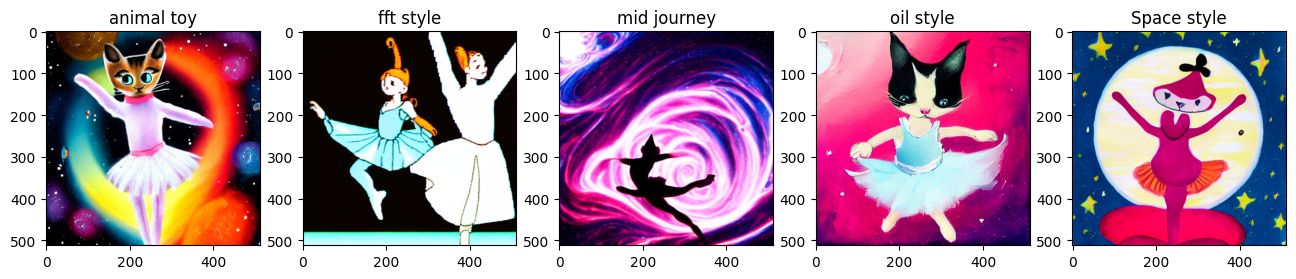

In [19]:
show_images(outputs_no_loss,image_names)
show_images(outputs_loss,image_names)